In [49]:
%pylab inline
import corner
from astropy.io import fits
import dtdutils
reload(dtdutils)
import dtdplotutils as plot_dtd
reload(plot_dtd)

Populating the interactive namespace from numpy and matplotlib


<module 'dtdplotutils' from 'dtdplotutils.pyc'>

## Plot DTDs

In [52]:

#All the data are in units of PNe/1.0e6 solar masses.
def read_chains(filePrefix='', objName='', obj_subtype='All', sfhBinType=''):
    #Returns the nominal, high, low chains
    data_nominal, header = fits.getdata(filePrefix+'LMC_MCMC_DTD_'+objName+obj_subtype+'_'+sfhBinType+'_Nominal.fits', 0, header=True)
    data_low, header = fits.getdata(filePrefix+'LMC_MCMC_DTD_'+objName+obj_subtype+'_'+sfhBinType+'_Lowlim.fits', 0, header=True)
    data_high, header = fits.getdata(filePrefix+'LMC_MCMC_DTD_'+objName+obj_subtype+'_'+sfhBinType+'_Highlim.fits', 0, header=True)
    ndim = data_nominal.shape[2]
    data_nominal = data_nominal.reshape((-1, ndim))
    data_low = data_low.reshape((-1, ndim))
    data_high = data_high.reshape((-1, ndim))
    return data_nominal, data_low, data_high

def string_filenum(ind):
    #Returns the file number of randomized SFH DTDs in 00x format
    return ''.join(['0' for i in range(3 - len(str(ind)))])+str(ind)

    
def plot_dtds(data_nom_arr, data_low_arr, data_high_arr, objName, obj_subtype, sfhBinType, \
              colorScheme='bmh', show_errors = False, show_uplims=False):
    
    color_options = {'bmh':[u'#348ABD', u'#A60628',u'#467821',  u'#D55E00',u'#CC79A7',\
                            u'#56B4E9', u'#009E73', u'#F0E442', u'#0072B2'],
                    'seaborn-colorblind':[u'#0072B2', u'#009E73', u'#D55E00', u'#CC79A7', u'#F0E442',\
                                          u'#56B4E9'],
                     'rgb':['r', 'g', 'b', 'k', 'm'],
                    'seq-blue':reversed(['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#74a9cf','#3690c0','#0570b0',\
                                 '#045a8d','#023858'])}
    colors = iter(color_options[colorScheme])
    labels = iter(obj_subtype)
    
    plt.rc('font', family='serif')
    plt.figure(figsize=(6,5))
    for data_nominal, data_low, data_high in zip(data_nom_arr, data_low_arr, data_high_arr):
        
        ages, agebin_1, agebin_2 = dtdutils.sfh_ageBins(sfhBinType)

        #Extracting the signals (or lack thereof) with statistical errors
        dtd, dtd_error, isuplim = dtdutils.dtd_staterrors(data_nominal)
      
        #dtd_SFH, dtd_error_SFH, isuplim_SFH = dtdutils.dtd_staterrors(data_randSFH*1.0e6)
        
        

        #Extracting the systematic errors due to different SFHs
        dtd_sad_error_low, dtd_sad_error_high = dtdutils.dtd_saderrors(data_low, data_nominal, data_high)

        dtd_no = np.array([signal if isuplim[i] else 0. for i, signal in enumerate(dtd)])
        dtd_yes = np.array([signal  if np.invert(isuplim[i]) else 0. for i,signal in enumerate(dtd)])
        
        if show_errors:
            dtd_y = np.array([signal for i, signal in enumerate(dtd) if np.invert(isuplim[i])])
            ages_y = np.array([age for i, age in enumerate(ages) if np.invert(isuplim[i])])
            
            dtd_yes_error = np.array([err for i, err in enumerate(dtd_error) if np.invert(isuplim[i])])          
            dtd_yes_error_low = dtd_yes_error[:,0]
            dtd_yes_error_high = dtd_yes_error[:,1]
                
            dtd_yes_sad_error_low = np.array([err for i, err in enumerate(dtd_sad_error_low) if np.invert(isuplim[i])])
            dtd_yes_sad_error_high = np.array([err for i, err in enumerate(dtd_sad_error_high) if np.invert(isuplim[i])])

            dtd_yes_toterr_low = np.sqrt(dtd_yes_error_low**2 + dtd_yes_sad_error_low**2)
            dtd_yes_toterr_high = np.sqrt(dtd_yes_error_high**2 + dtd_yes_sad_error_high**2)

            
        #Separating bins with upper limits
        if False:
            agebin_1_no = agebin_1[dtd_no[:,1].astype(int)]
            agebin_2_no = agebin_2[dtd_no[:,1].astype(int)]
    
        
        #Separating bins with signals
        if False:
            agebin_1_yes = agebin_1[dtd_yes[:,1].astype(int)]
            agebin_2_yes = agebin_2[dtd_yes[:,1].astype(int)]
            dtd_yes_sad_error_low = dtd_sad_error_low[dtd_yes[:,1].astype(int)]
            dtd_yes_sad_error_high = dtd_sad_error_high[dtd_yes[:,1].astype(int)]
       
            
        #Total error

        with plt.style.context(('bmh')):
            #This temporarily sets the plotting style. Do not use plt.style.use()
            clr = colors.next()
            if False:
                plt.plot(np.vstack((agebin_1_yes/1.0e6, agebin_2_yes/1.0e6)).T.flatten(), np.repeat(dtd_yes[:,0],2),\
                         color=clr, ls='-',lw=2.0, label=labels.next())
                plt.plot(np.vstack((agebin_1_no/1.0e6, agebin_2_no/1.0e6)).T.flatten(), np.repeat(dtd_no[:,0],2),\
                         color=clr, ls='--', lw=2.0)
                plt.errorbar(ages_y/1.0e6, dtd_y[:,0], yerr=(dtd_yes_error_low, dtd_yes_error_high), \
                             uplims=False, fmt='', ls='', ecolor='k', label='$\sigma$ = stat')
                plt.errorbar(ages_yes/1.0e6, dtd_yes[:,0], yerr=(dtd_yes_toterr_low, dtd_yes_toterr_high), \
                             uplims=False, fmt='', ls='', ecolor='k', label='$\sigma$ = stat+SFH')
            #plt.axvspan(np.repeat(dtd,2), )
            
            x_axis = np.vstack((agebin_1/1.0e6, agebin_2/1.0e6)).T.flatten()
            y_axis = np.repeat(dtd_yes,2)
            plt.plot(x_axis, y_axis, color = clr, ls = '-', lw=2.0)
            #plt.gca().fill_between(x_axis, 0., y_axis, facecolor=clr, alpha=0.8, label=labels.next())
            plt.gca().fill_between(x_axis, 0., y_axis, facecolor=clr, alpha=0.8, label='Detection')
            if show_errors:
                plt.errorbar(ages_y/1.0e6, dtd_y, yerr=(dtd_yes_toterr_low, dtd_yes_toterr_high), \
                         uplims=False, fmt='', ls='', ecolor='k', label='$\sigma$ = stat+SFH')
            if show_uplims:
                plt.plot(x_axis, np.repeat(dtd_no,2), color=clr, ls='--', lw=2.0, label='Non-detection')


    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Time [Myrs]', fontsize=15)
    plt.xlim(5.0, 2.0e4)
#    plt.ylim(1.0e-1,5.0e2)
    plt.title('OGLE {0} - {1}'.format(objName, sfhBinType))#
    plt.ylabel(r'$\rm{\Psi\ T_{vis}}$ $\rm{\left(Number/10^6\ M_{\odot}\right)}$', fontsize=15)
#    plt.title('Cepheids', fontsize=18)
#    plt.ylabel(r'DTD $\rm{\left(Number/10^6\ M_{\odot}\right)}$', fontsize=15)
    plt.tick_params(axis='y', labelsize=14)
    plt.tick_params(axis='x', labelsize=14)
    plt.legend(numpoints=1)
#    plt.savefig(outfilePrefix+'DTD_'+objName+'_'+sfhBinType+'.pdf', dpi=150)
    plt.show()

def plot_dtds_randSFH(data_nom_arr, data_low_arr, data_randSFH, data_high_arr, objName, obj_subtype, sfhBinType, \
              colorScheme='bmh', show_errors = False, show_uplims=False):
    
    color_options = {'bmh':[u'#348ABD', u'#A60628',u'#467821',  u'#D55E00',u'#CC79A7',\
                            u'#56B4E9', u'#009E73', u'#F0E442', u'#0072B2'],
                    'seaborn-colorblind':[u'#0072B2', u'#009E73', u'#D55E00', u'#CC79A7', u'#F0E442',\
                                          u'#56B4E9'],
                     'rgb':['r', 'g', 'b', 'k', 'm'],
                    'seq-blue':reversed(['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#74a9cf','#3690c0','#0570b0',\
                                 '#045a8d','#023858'])}
    colors = iter(color_options[colorScheme])
    labels = iter(obj_subtype)
    
    plt.rc('font', family='serif')
    plt.figure(figsize=(6,5))
    #Iterating through each subtype
    for data_nominal, data_low, data_high in zip(data_nom_arr, data_low_arr, data_high_arr):
        
        ages, agebin_1, agebin_2 = dtdutils.sfh_ageBins(sfhBinType)

        #Extracting the signals (or lack thereof) with statistical errors
        dtd, dtd_error, isuplim = dtdutils.dtd_staterrors(data_nominal*1.0e6)
        
        #dtd_SFH, dtd_error_SFH, isuplim_SFH = dtdutils.dtd_staterrors(data_randSFH*1.0e6)
        
        

        #Extracting the systematic errors due to different SFHs
        dtd_sad_error_low, dtd_sad_error_high = dtdutils.dtd_saderrors(data_low*1.0e6, data_nominal*1.0e6, data_high*1.0e6)

        dtd_no = np.array([signal if isuplim[i] else 0. for i, signal in enumerate(dtd)])
        dtd_yes = np.array([signal  if np.invert(isuplim[i]) else 0. for i,signal in enumerate(dtd)])
        
        if show_errors:
            dtd_y = np.array([signal for i, signal in enumerate(dtd) if np.invert(isuplim[i])])
            ages_y = np.array([age for i, age in enumerate(ages) if np.invert(isuplim[i])])
            
            dtd_yes_error = np.array([err for i, err in enumerate(dtd_error) if np.invert(isuplim[i])])          
            dtd_yes_error_low = dtd_yes_error[:,0]
            dtd_yes_error_high = dtd_yes_error[:,1]
            
            dtd_yes_sad_error_low = np.array([err for i, err in enumerate(dtd_sad_error_low) if np.invert(isuplim[i])])
            dtd_yes_sad_error_high = np.array([err for i, err in enumerate(dtd_sad_error_high) if np.invert(isuplim[i])])
   
            dtd_yes_toterr_low = np.sqrt(dtd_yes_error_low**2 + dtd_yes_sad_error_low**2)
            dtd_yes_toterr_high = np.sqrt(dtd_yes_error_high**2 + dtd_yes_sad_error_high**2)

            
        #Separating bins with upper limits
        if False:
            agebin_1_no = agebin_1[dtd_no[:,1].astype(int)]
            agebin_2_no = agebin_2[dtd_no[:,1].astype(int)]
    
        
        #Separating bins with signals
        if False:
            agebin_1_yes = agebin_1[dtd_yes[:,1].astype(int)]
            agebin_2_yes = agebin_2[dtd_yes[:,1].astype(int)]
            dtd_yes_sad_error_low = dtd_sad_error_low[dtd_yes[:,1].astype(int)]
            dtd_yes_sad_error_high = dtd_sad_error_high[dtd_yes[:,1].astype(int)]
       
            
        #Total error

        with plt.style.context(('bmh')):
            #This temporarily sets the plotting style. Do not use plt.style.use()
            clr = colors.next()
            if False:
                plt.plot(np.vstack((agebin_1_yes/1.0e6, agebin_2_yes/1.0e6)).T.flatten(), np.repeat(dtd_yes[:,0],2),\
                         color=clr, ls='-',lw=2.0, label=labels.next())
                plt.plot(np.vstack((agebin_1_no/1.0e6, agebin_2_no/1.0e6)).T.flatten(), np.repeat(dtd_no[:,0],2),\
                         color=clr, ls='--', lw=2.0)
                plt.errorbar(ages_y/1.0e6, dtd_y[:,0], yerr=(dtd_yes_error_low, dtd_yes_error_high), \
                             uplims=False, fmt='', ls='', ecolor='k', label='$\sigma$ = stat')
                plt.errorbar(ages_yes/1.0e6, dtd_yes[:,0], yerr=(dtd_yes_sad_error_low, dtd_yes_sad_error_high), \
                             uplims=False, fmt='', ls='', ecolor='k', label='$\sigma$ = stat+SFH')
            #plt.axvspan(np.repeat(dtd,2), )
            
            x_axis = np.vstack((agebin_1/1.0e6, agebin_2/1.0e6)).T.flatten()
            y_axis = np.repeat(dtd_yes,2)
            plt.plot(x_axis, y_axis, color = clr, ls = '-', lw=2.0)
            plt.gca().fill_between(x_axis, 0., y_axis, facecolor=clr, alpha=0.8, label=labels.next())
            if show_errors:
                plt.errorbar(ages_y/1.0e6, dtd_y, yerr=(dtd_yes_sad_error_low, dtd_yes_sad_error_high), \
                         uplims=False, fmt='', ls='', ecolor='k', label='$\sigma$ = stat+SFH')
            if show_uplims:
                plt.plot(x_axis, np.repeat(dtd_no,2), color=clr, ls='--', lw=2.0)


    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Time [Myrs]', fontsize=15)
    plt.xlim(5.0, 2.0e4)
    plt.ylim(1.0e-1,5.0e2)
    plt.title('OGLE {0} - {1}'.format(objName, sfhBinType))
    plt.ylabel(r'$\rm{\Psi\ T_{vis}}$ $\rm{\left(Number/10^6\ M_{\odot}\right)}$', fontsize=15)
    plt.tick_params(axis='y', labelsize=14)
    plt.tick_params(axis='x', labelsize=14)
    plt.legend(numpoints=1)
    plt.savefig(outfilePrefix+'DTD_'+objName+'_'+sfhBinType+'.pdf', dpi=150)
    plt.show()


### I. RR Lyrae

In [6]:
#~~~~~~~~ INPUT ~~~~~~~~~~~~~~~~~~~#
outfilePrefix = 'DTD_Plots/'
objName = 'RRLyrae'
obj_subtype_arr = ['All']
filePrefix = 'MCMC_DTD_fits/DTD_'+objName+'/'
sfhBinType = 'Unbinned'
nIterations = 100
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

chain_nom = []
chain_low = []
chain_high = []
for obj_subtype in obj_subtype_arr:
    x_nom, x_low, x_high = plot_dtd.read_chains(filePrefix=filePrefix, objName=objName, \
                                                        obj_subtype=obj_subtype, sfhBinType=sfhBinType)
    chain_nom.append(x_nom)
    chain_low.append(x_low)
    chain_high.append(x_high)

In [17]:
len(chain_nom[0])

240000

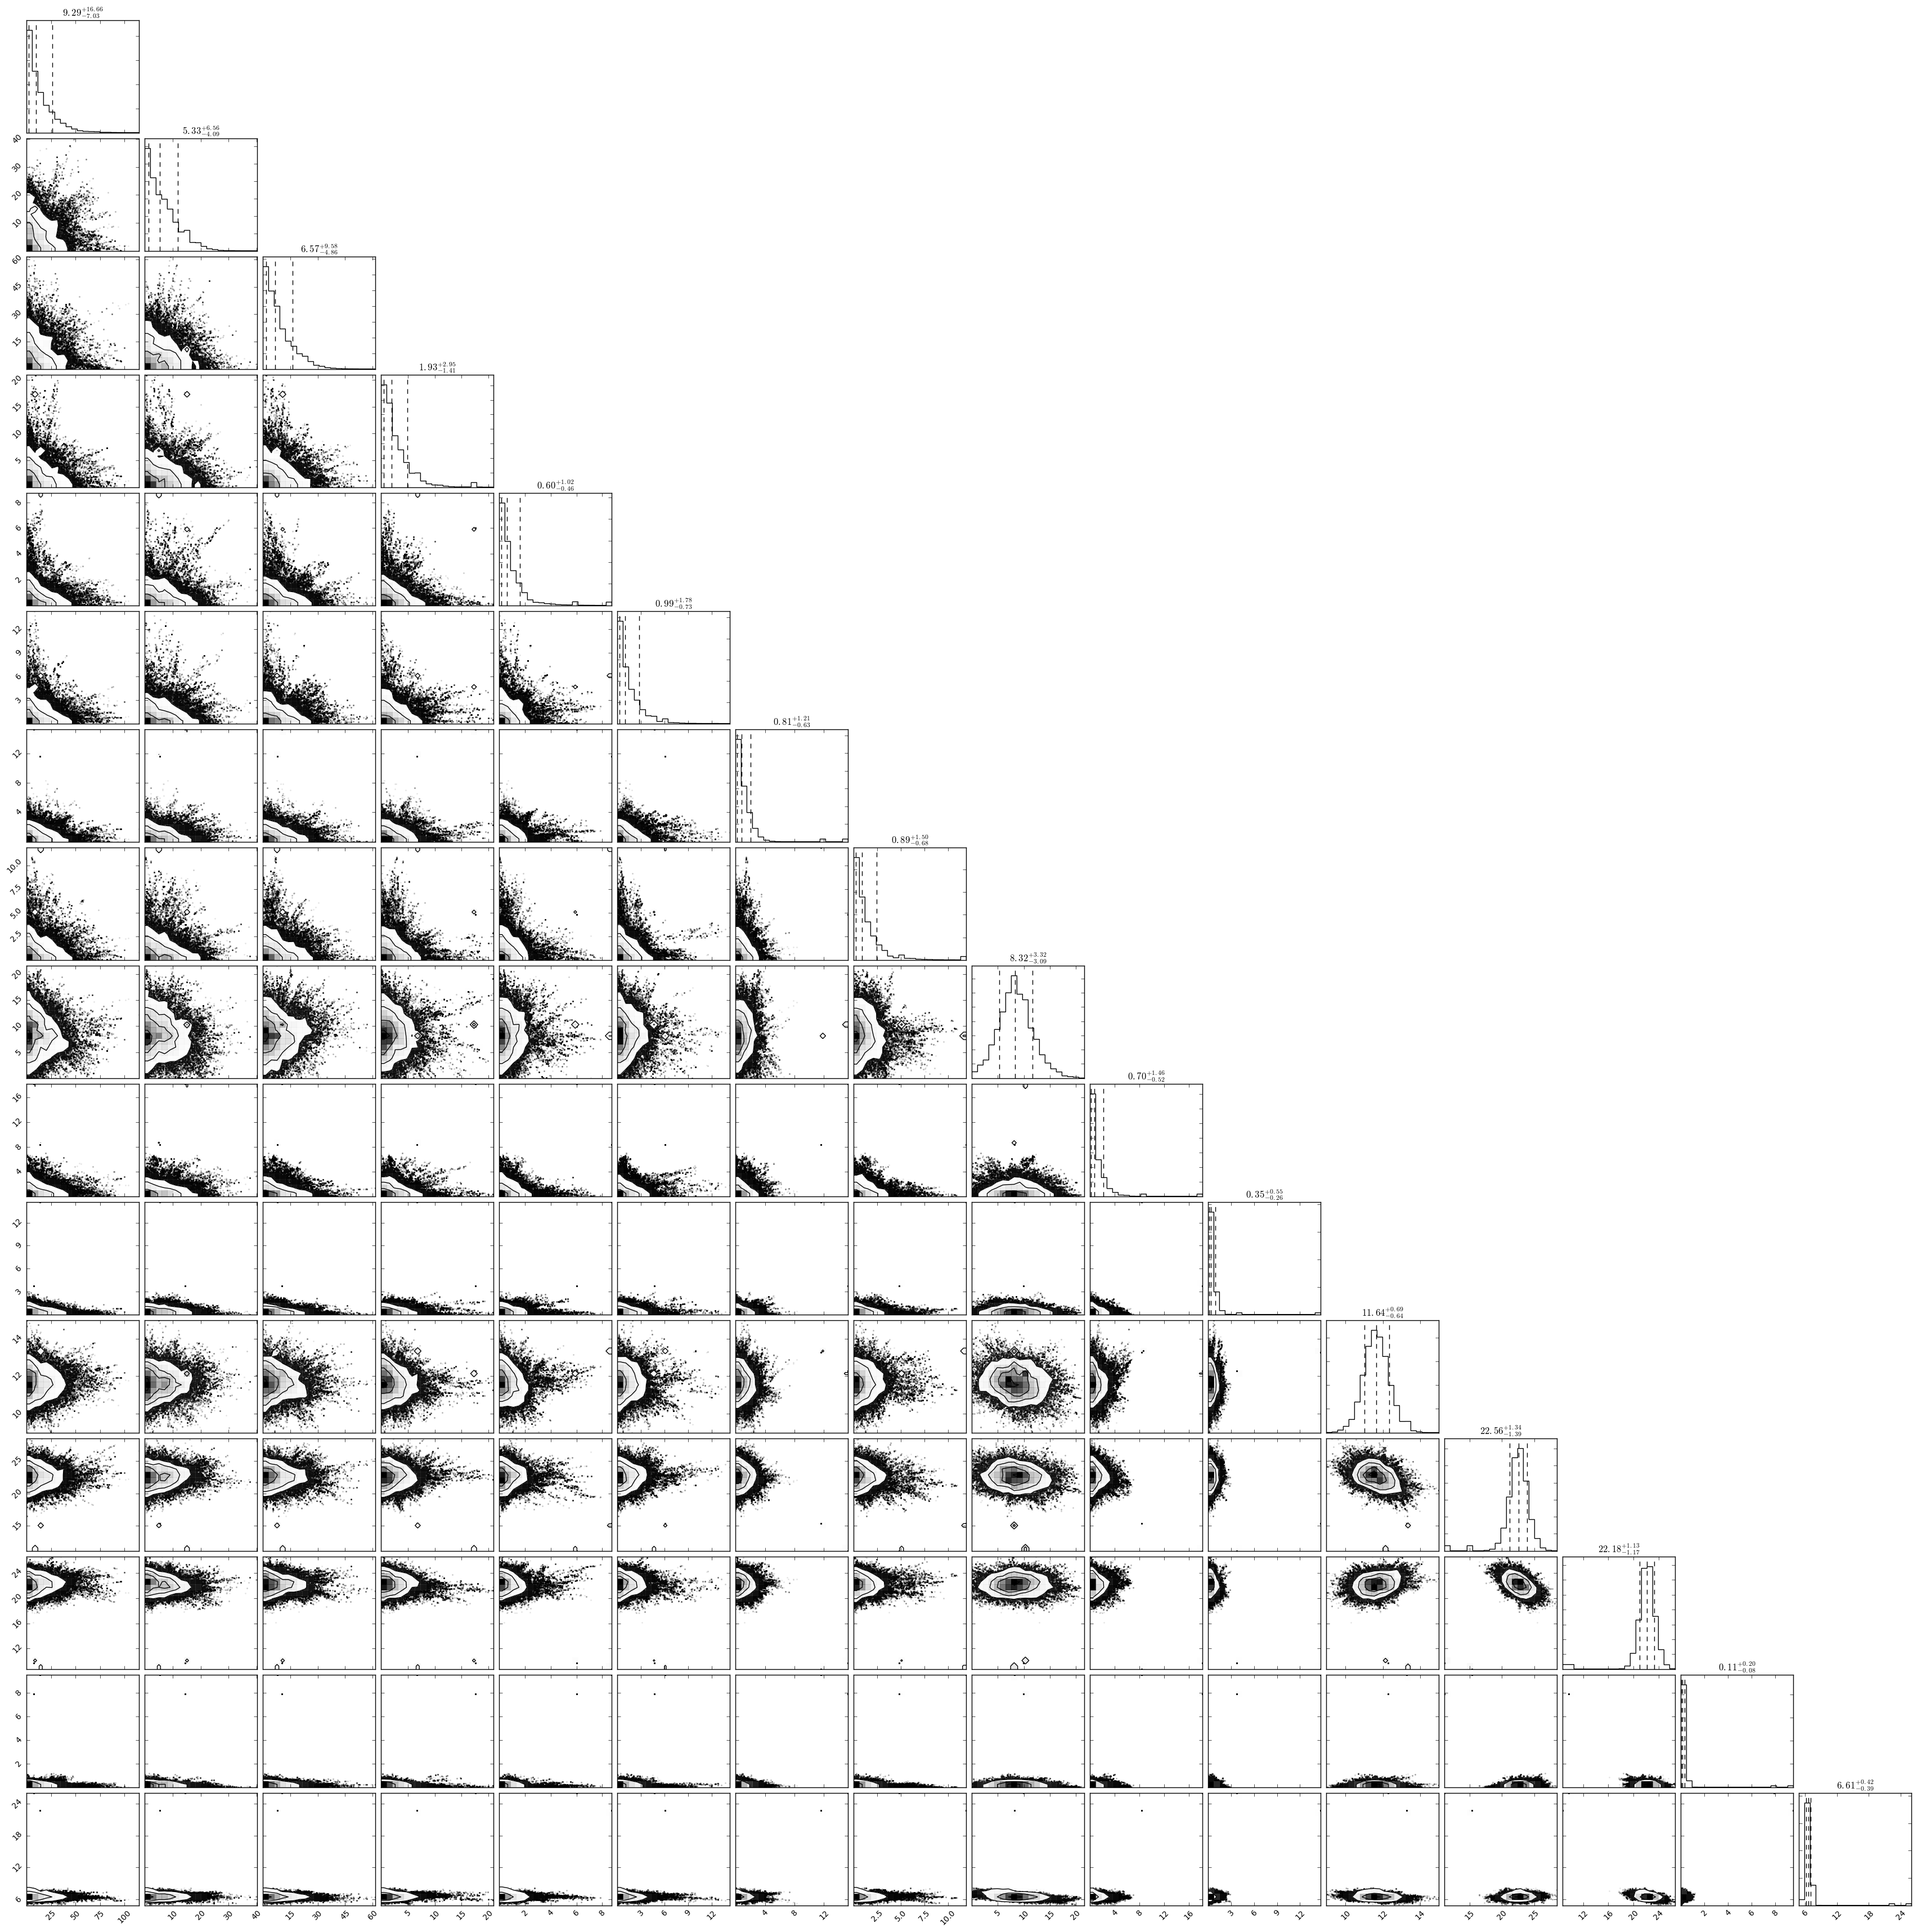

In [5]:
fig = corner.corner(chain_high[0]*1.0e6,\
               quantiles=[0.16, 0.5, 0.84],  show_titles=True, title_kwargs={"fontsize": 12}),

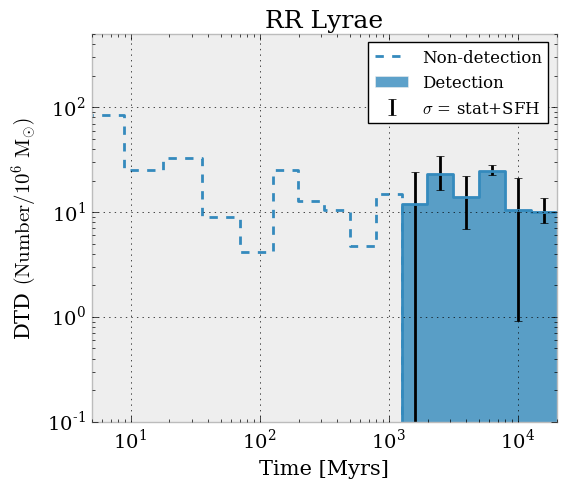

In [9]:
plot_dtds(chain_nom, chain_low, chain_high, objName, obj_subtype_arr, sfhBinType=sfhBinType, \
          colorScheme='bmh', show_errors=True, show_uplims = True)

In [10]:
#~~~~~~~~ INPUT ~~~~~~~~~~~~~~~~~~~#
outfilePrefix = 'DTD_Plots/'
objName = 'RRLyrae'
obj_subtype_arr = ['All']
filePrefix = 'MCMC_DTD_fits/DTD_'+objName+'/'
sfhBinType = 'Unbinned'
nIterations = 100
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

masterchain_randSFH = []
for i in range(nIterations):
    chain_randSFH, header = fits.getdata(filePrefix + 'LMC_MCMC_DTD_' + objName + obj_subtype_arr[0] + '_' + sfhBinType + \
                                         '_Iter' + string_filenum(i) + '.fits', 0, header=True)
    masterchain_randSFH.append(chain_randSFH)
    
masterchain_randSFH = np.asarray(masterchain_randSFH)

In [13]:
ndim = masterchain_randSFH.shape[3]
chain_randSFH = masterchain_randSFH.reshape((-1, ndim))

nParams = chain_randSFH.shape[1]   #Number of DTD parameters
chainLength = chain_randSFH.shape[0]/nIterations*1.0  #Length of each DTD Markov Chain
chain_SFH = np.zeros((nParams, chainLength))
for par in range(nParams):
    chain_SFH[par] = np.random.choice(chain_randSFH[:,par]*1.0e6, size=chainLength, replace=False)
    #You want the size of the randomly drawn chain to be the same size as the other chain, to 
    #normalize the statistical comparisons.
    
chain_SFH = chain_SFH.T

/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([[   1.27717618,    1.27511488,    2.35578205, ...,   23.52466717,
           6.30940575,   10.69380705],
       [  52.08881828,    8.11078517,   13.87396808, ...,   23.46660109,
          11.12361606,   11.0886965 ],
       [ 124.85050109,    3.75747997,    1.13506688, ...,   20.8986176 ,
          13.16952618,    9.91905954],
       ..., 
       [  38.68588293,    5.46819873,   22.26121121, ...,   18.54712092,
          10.63710762,   10.79859782],
       [  15.5064238 ,    9.54143832,   21.19549091, ...,   22.39002596,
          10.86416271,    9.97364026],
       [  88.81180993,    0.6211053 ,    8.84833765, ...,   19.18364427,
           9.25604776,   10.30601803]])

### II. Classical Cepheids

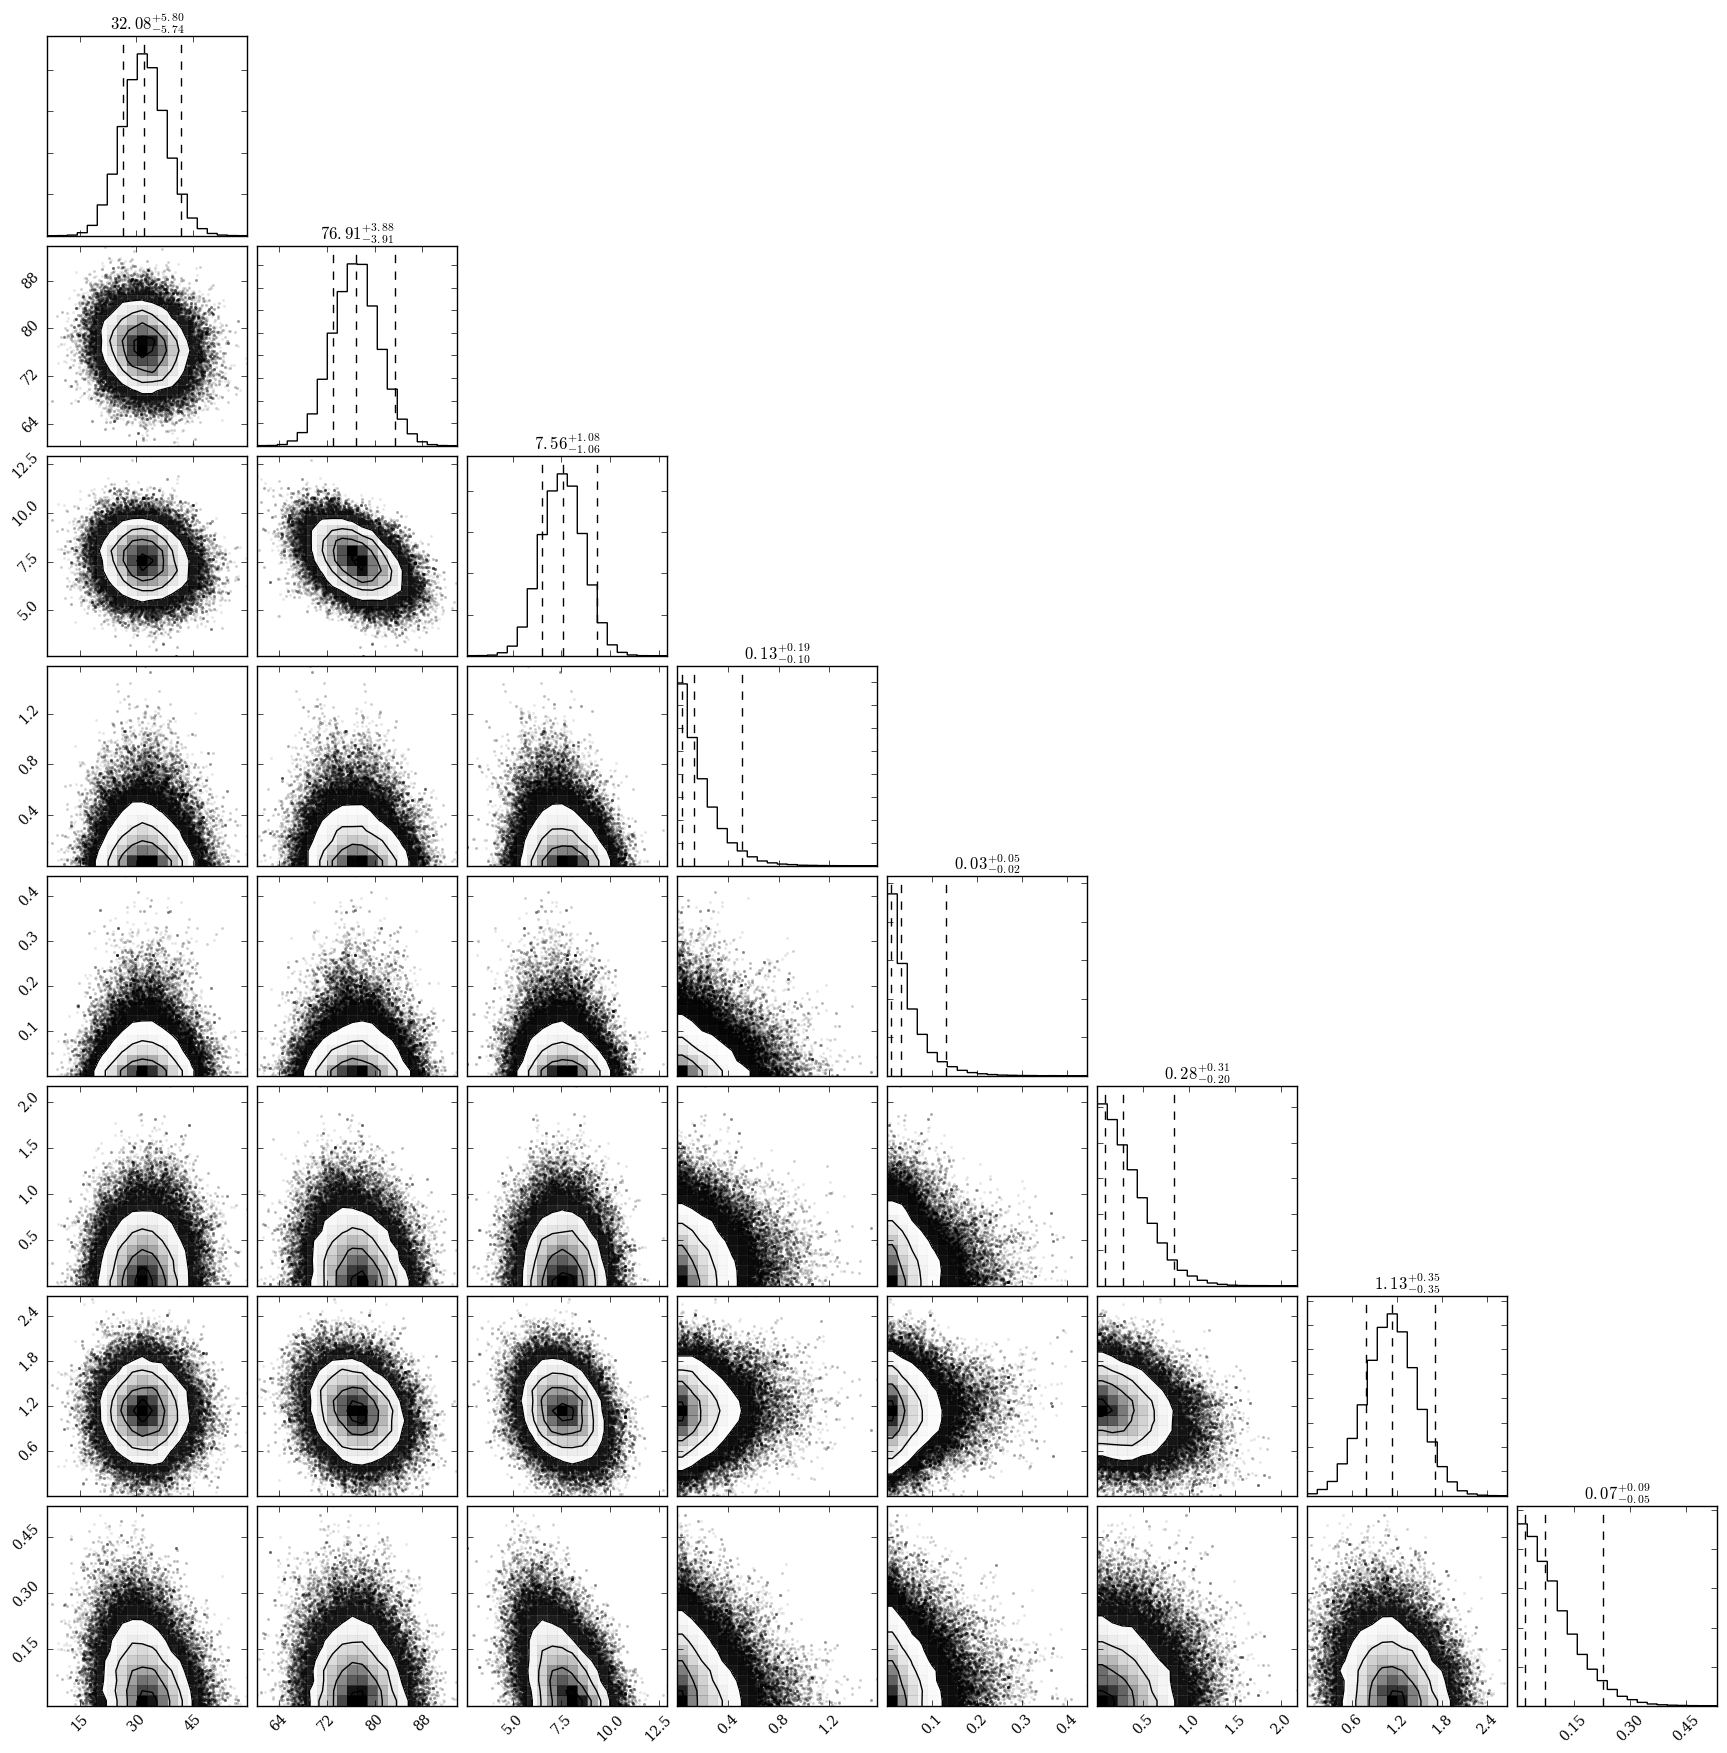

In [63]:
#~~~~~~~~ INPUT ~~~~~~~~~~~~~~~~~~~#
outfilePrefix = 'DTD_Plots/'
objName = 'Cepheids'
obj_subtype_arr = ['All']
filePrefix = 'MCMC_DTD_fits/DTD_'+objName+'/'
sfhBinType = 'Fine'
nIterations = 1
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

chain_nom = []
chain_low = []
chain_high = []
for obj_subtype in obj_subtype_arr:
    x_nom, x_low, x_high = plot_dtd.read_chains(filePrefix=filePrefix, objName=objName, \
                                                        obj_subtype=obj_subtype, sfhBinType=sfhBinType)
    chain_nom.append(x_nom)
    chain_low.append(x_low)
    chain_high.append(x_high)
    
fig = corner.corner(chain_nom[0]*1.0e6,\
               quantiles=[0.16, 0.5, 0.95],  show_titles=True, title_kwargs={"fontsize": 12})

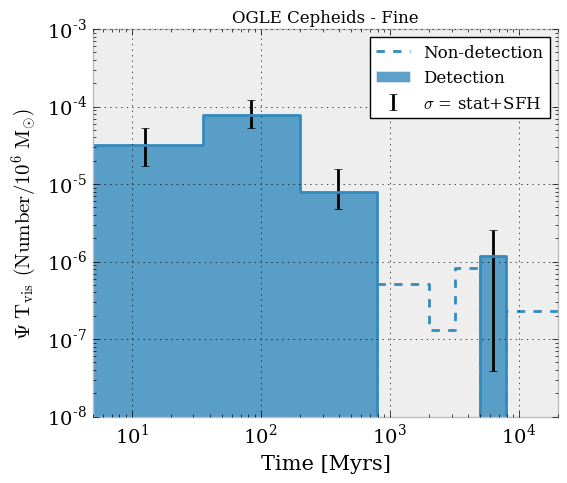

In [64]:
plot_dtds(chain_nom, chain_low, chain_high, objName, obj_subtype_arr, sfhBinType=sfhBinType, \
          colorScheme='bmh', show_errors=True, show_uplims = True)

In [65]:
plot_dtds_randSFH(chain_nom, [chain_SFH], objName, obj_subtype_arr, sfhBinType=sfhBinType, \
          colorScheme='bmh', show_errors=True, show_uplims = True)

NameError: name 'chain_SFH' is not defined

## III. Type II Cepheids

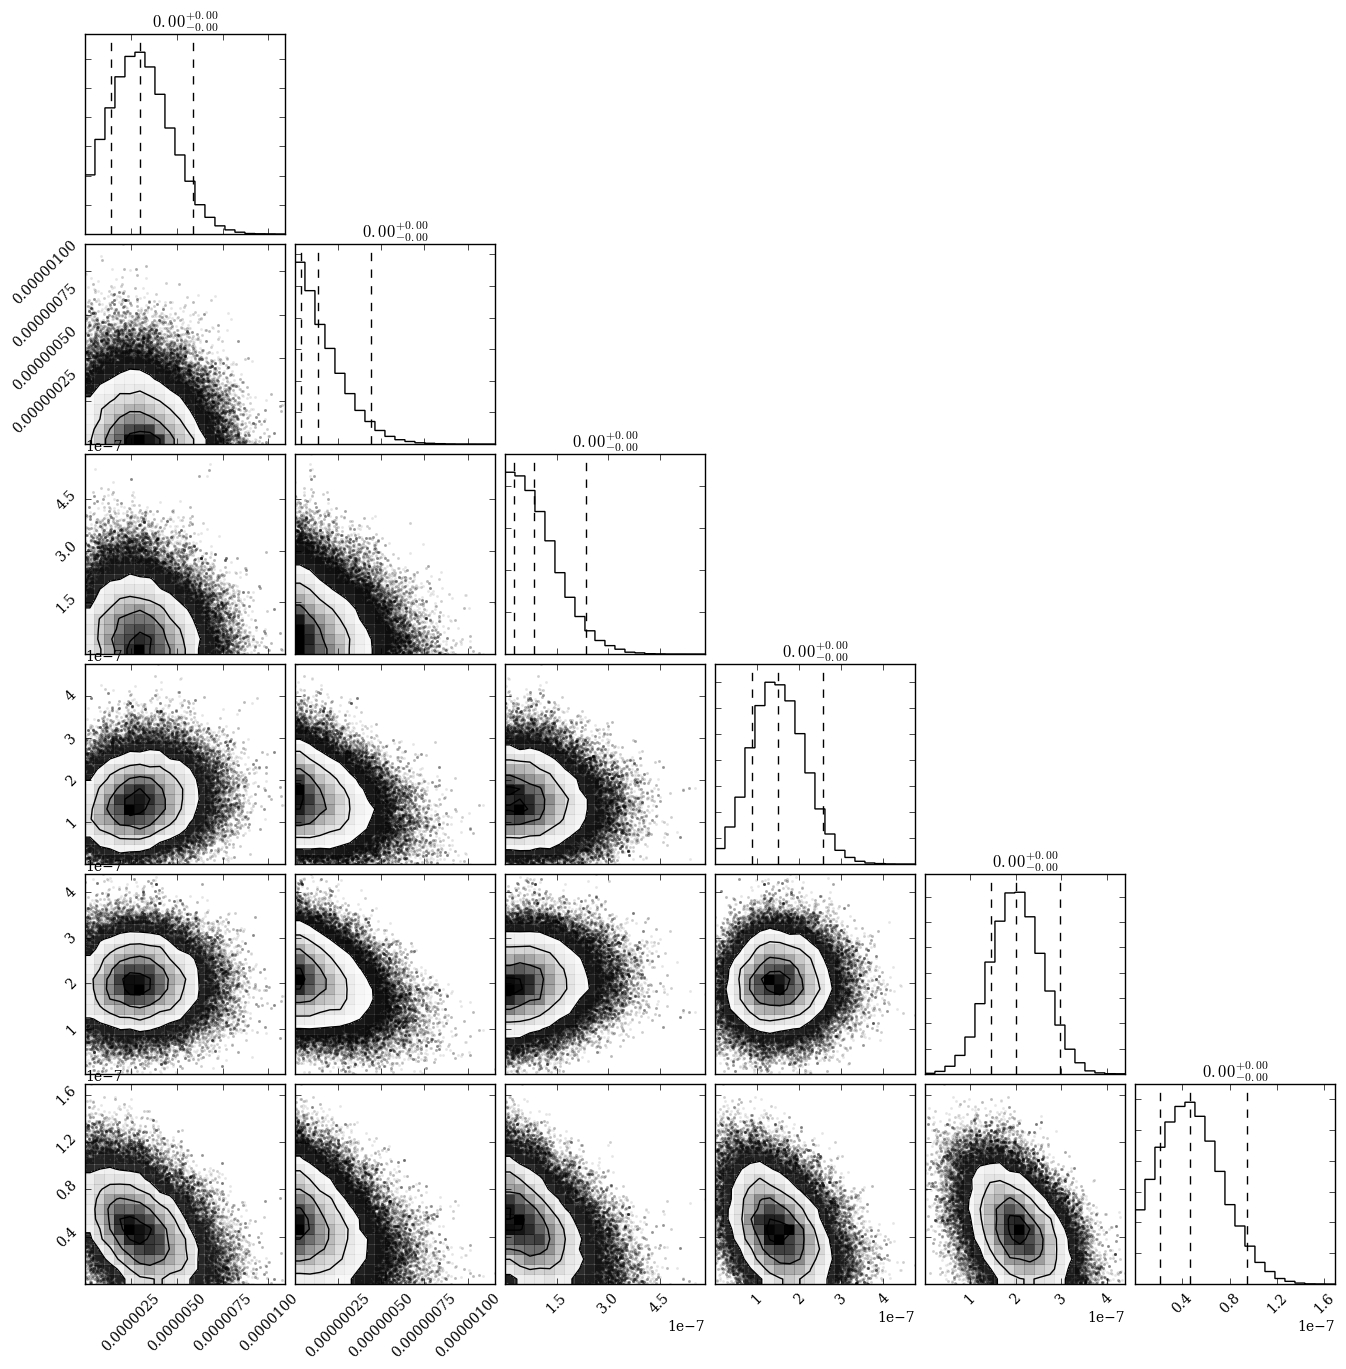

In [25]:
#~~~~~~~~ INPUT ~~~~~~~~~~~~~~~~~~~#
outfilePrefix = 'DTD_Plots/'
objName = 'Type2_Cepheids'
obj_subtype_arr = ['All']
filePrefix = 'MCMC_DTD_fits/DTD_'+objName+'/'
sfhBinType = 'Medium'
nIterations = 1
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

chain_nom = []
chain_low = []
chain_high = []
for obj_subtype in obj_subtype_arr:
    x_nom, x_low, x_high = plot_dtd.read_chains(filePrefix=filePrefix, objName=objName, \
                                                        obj_subtype=obj_subtype, sfhBinType=sfhBinType)
    chain_nom.append(x_nom)
    chain_low.append(x_low)
    chain_high.append(x_high)
    
fig = corner.corner(chain_nom[0],\
               quantiles=[0.16, 0.5, 0.95],  show_titles=True, title_kwargs={"fontsize": 12})

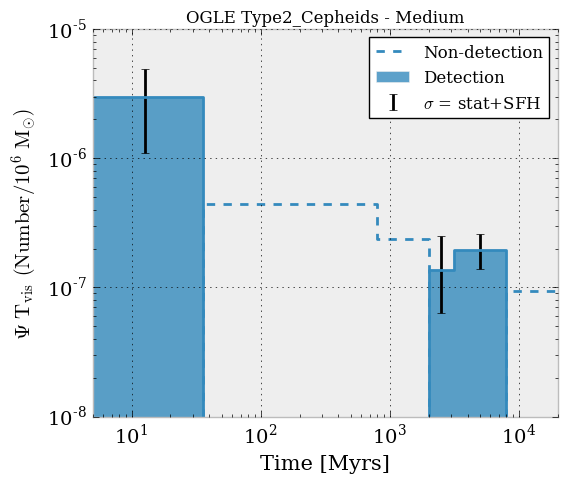

In [28]:
 plot_dtds(chain_nom, chain_low, chain_high, objName, obj_subtype_arr, sfhBinType=sfhBinType, \
          colorScheme='bmh', show_errors=True, show_uplims = True)

## IV. Anomalous Cepheids

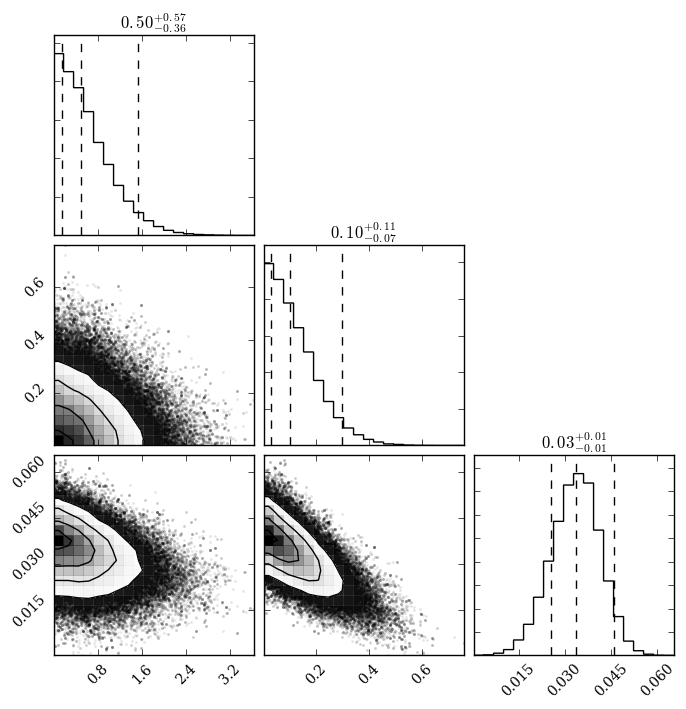

In [16]:
#~~~~~~~~ INPUT ~~~~~~~~~~~~~~~~~~~#
outfilePrefix = 'DTD_Plots/'
objName = 'Anom_Cepheids'
obj_subtype_arr = ['All']
filePrefix = 'MCMC_DTD_fits/DTD_'+objName+'/'
sfhBinType = 'Coarse'
nIterations = 1
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

chain_nom = []
chain_low = []
chain_high = []
for obj_subtype in obj_subtype_arr:
    x_nom, x_low, x_high = plot_dtd.read_chains(filePrefix=filePrefix, objName=objName, \
                                                        obj_subtype=obj_subtype, sfhBinType=sfhBinType)
    chain_nom.append(x_nom)
    chain_low.append(x_low)
    chain_high.append(x_high)
    
fig = corner.corner(chain_nom[0]*1.0e6,\
               quantiles=[0.16, 0.5, 0.95],  show_titles=True, title_kwargs={"fontsize": 12})

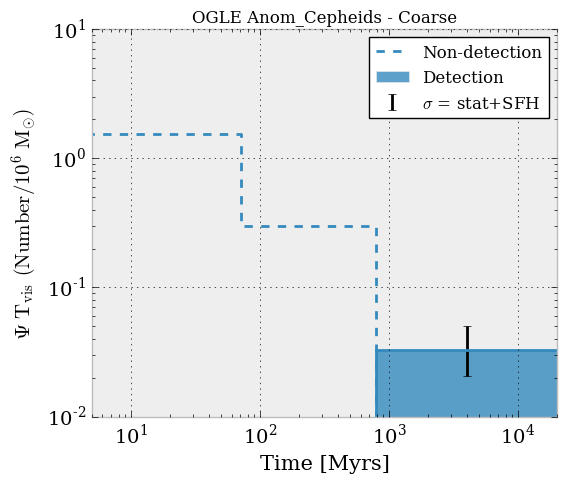

In [17]:
plot_dtds(chain_nom, chain_low, chain_high, objName, obj_subtype_arr, sfhBinType=sfhBinType, \
          colorScheme='bmh', show_errors=True, show_uplims = True)

## Randomized Star-Formation Histories


Here I'll figure out how to measure errors in the DTD from randomized SFHs. 

In [54]:
def string_filenum(ind):
    #Returns the file number of randomized SFH DTDs in 00x format
    return ''.join(['0' for i in range(3 - len(str(ind)))])+str(ind)

In [55]:
#~~~~~~~~ INPUT ~~~~~~~~~~~~~~~~~~~#
outfilePrefix = 'DTD_Plots/'
objName = 'Cepheids'
obj_subtype_arr = ['All']
filePrefix = 'MCMC_DTD_fits/DTD_'+objName+'/'
sfhBinType = 'Fine'
nIterations = 100
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

masterchain_randSFH = []
for i in range(nIterations):
    chain_randSFH, header = fits.getdata(filePrefix + 'LMC_MCMC_DTD_' + objName + obj_subtype_arr[0] + '_' + sfhBinType + \
                                         '_Iter' + string_filenum(i) + '.fits', 0, header=True)
    masterchain_randSFH.append(chain_randSFH)

In [56]:
masterchain_randSFH = np.asarray(masterchain_randSFH)

In [57]:
masterchain_randSFH[0,:,:,0].shape

(80, 3000)

(99,)


/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in multiply


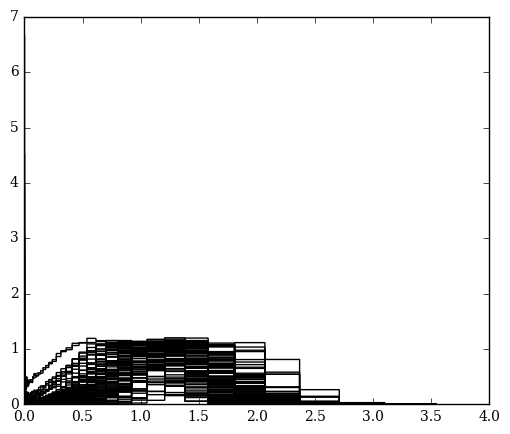

In [62]:
plt.rc('font', family='serif')
param = 6
minbin = np.log10(np.min(masterchain_randSFH[:,:,:,param])*1.0e6)
maxbin = np.log10(np.max(masterchain_randSFH[:,:,:,param])*1.0e6)
bins = np.logspace(minbin, maxbin, 100)
p_x = np.ones(bins.size-1)
print p_x.shape
for i in range(nIterations):
    n, binedges = np.histogram(masterchain_randSFH[i,:,:,param].flatten()*1.0e6, bins=bins)
    p_x=p_x*n

if 1:
    plt.figure(figsize=(6,5))
    for i in range(nIterations):
        plt.hist(masterchain_randSFH[i,:,:,param].flatten()*1.0e6, normed=True, bins=bins, color='k',histtype='step')


**Difference between bins = np.arange() and bins = np.lin/logspace().** The former gives you bins of the same size and at the same locations, while the latter only gives you the same number of bins by adjusting the locations and size. You can't use the latter for analyzing PDFs, unless you're dealing with a large logarithmic range. The latter also helps when displaying histograms. 

### Method 1: Combine all 100 x nWalkers x nChains datapoints into a single histogram.

0.598498522683
0.0881952045413


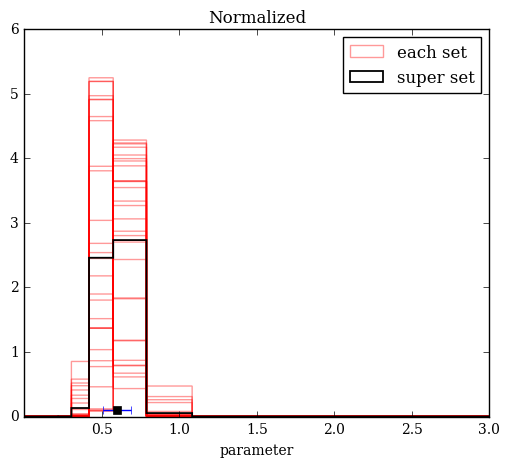

In [13]:
plt.rc('font', family='serif')
param=2
bins = np.logspace(-3, 1, 30)
plt.figure(figsize=(6,5))
for i in range(28):
    plt.hist(masterchain_randSFH[i,:,:,param].flatten()*1.0e6, normed=True, bins=bins, alpha=0.4,color='r',histtype='step')
plt.hist(masterchain_randSFH[29,:,:,param].flatten()*1.0e6, normed=True, bins=bins, alpha=0.4,color='r',histtype='step',\
            label='each set')
plt.hist(masterchain_randSFH[:,:,:,param].flatten()*1.0e6, normed=True, bins=bins, lw=1.3, color='k',histtype='step', 
        label='super set')
plt.plot(np.mean(masterchain_randSFH[:,:,:,param].flatten()*1.0e6), [0.1], 'ks')
plt.errorbar(np.mean(masterchain_randSFH[:,:,:,param].flatten()*1.0e6), [0.1], \
             xerr=np.std(masterchain_randSFH[:,:,:,param].flatten()*1.0e6), fmt='', ls='')
plt.xlabel('parameter')
plt.title('Normalized')
#plt.ylim(0, 0.2)
plt.legend()
#plt.xscale('log')
plt.xlim(1.0e-3,3.0)
print np.mean(masterchain_randSFH[:,:,:,param].flatten()*1.0e6)
print np.std(masterchain_randSFH[:,:,:,param].flatten()*1.0e6)
plt.show()


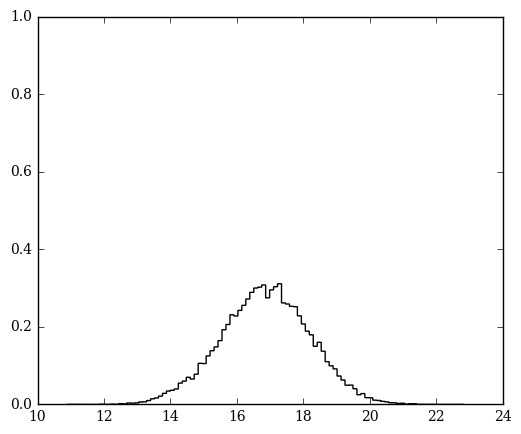

In [109]:
plt.rc('font', family='serif')
param=12
bins = np.arange(0, 200, 1.)
plt.figure(figsize=(6,5))
plt.hist(masterchain_randSFH[20,:,:,param].flatten()*1.0e6, normed=True, bins=100, color='k',histtype='step')
plt.ylim(0, 1)
#plt.xscale('log')
#plt.xlim(0,50)
plt.show()


### Method 2: Multiply the PDFs bin-by-bin

(199,)



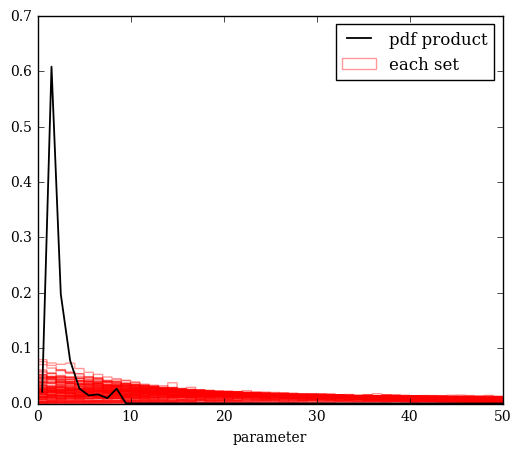

In [128]:
plt.rc('font', family='serif')
param, binw = 0, 1.0
minbin = np.log10(np.min(masterchain_randSFH[:,:,:,param])*1.0e6)
maxbin = np.log10(np.max(masterchain_randSFH[:,:,:,param])*1.0e6)
bins = np.arange(0, 200, binw)

p_x = np.ones(bins.size-1)
print p_x.shape
for i in range(nIterations):
    n, binedges = np.histogram(masterchain_randSFH[i,:,:,param].flatten()*1.0e6, density=True, bins=bins)
    p_x=p_x*n


plt.figure(figsize=(6,5))
for i in range(99):
    plt.hist(masterchain_randSFH[i,:,:,param].flatten()*1.0e6, normed=True, bins=bins, alpha=0.4, color='r',histtype='step')
plt.hist(masterchain_randSFH[i,:,:,param].flatten()*1.0e6, normed=True, bins=bins, alpha=0.4, color='r',histtype='step',\
        label='each set')
            
normed_p_x = p_x/np.sum(p_x*binw)
plt.plot(bins[:-1]+0.5, normed_p_x, 'k-', lw=1.3, label='pdf product')
plt.xlabel('parameter')
#plt.ylim(0, 0.06)
#plt.xscale('log')
plt.xlim(0,50)
plt.legend()
print 
plt.show()


## Clerical 

In [6]:
from astropy.io import ascii
obj_subtype='RRe'
fileName = 'InputFiles/OGLE_LMC_RRLyrae.txt'
data = ascii.read(fileName)
data = data if obj_subtype=='All' else data[data['Type']==obj_subtype]
data['RA'].size

1269

In [24]:
data['RA']

<Column name='RA' dtype='str11' length=1269>
 4:31:18.61
 4:31:59.16
 4:33:01.64
 4:33:54.84
 4:34:20.48
 4:34:47.04
 4:34:47.28
 4:35:15.77
 4:35:25.57
 4:36:14.42
 4:36:32.23
 4:38:10.93
        ...
 6:09:27.62
 6:09:35.40
 6:10:37.87
 6:10:50.21
 6:11:24.73
 6:11:30.15
 6:11:37.96
 6:12:14.70
 6:13:25.05
 6:14:23.18
 6:14:45.63
 6:15:22.31

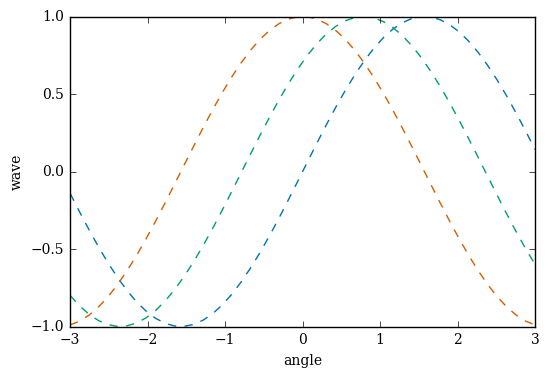

In [124]:
x  = np.linspace(-3,3)
y1 = [np.sin(x), np.sin(x+(np.pi/4.)), np.sin(x+(np.pi/2.))]

plt.figure()
for y in y1:
    with plt.style.context(('seaborn-colorblind')):
        plt.plot(x, y, '--', )

plt.xlabel('angle')
plt.ylabel('wave')
plt.show()


In [117]:
a = np.linspace(1,10, 10)
b = np.linspace(2, 20, 10)
color = ['color1', 'color2', 'color3', 'color4']
len([a,b])
color[:len([a,b])]

['color1', 'color2']

In [123]:
for i, (x,y) in enumerate(zip(a,b)):
    print i, x, y

0 1.0 2.0
1 2.0 4.0
2 3.0 6.0
3 4.0 8.0
4 5.0 10.0
5 6.0 12.0
6 7.0 14.0
7 8.0 16.0
8 9.0 18.0
9 10.0 20.0


In [2]:
color = {'a':2, 'b':3}

In [4]:
color_options = {'non-seq':['#e41a1c', '#377eb8', '#4daf4a', '#984ea3','#ff7f00', '#ffff33', '#a65628', '#f781bf'],\
                'seq':['#faxes.titlesize : 24
axes.labelsize : 20
lines.linewidth : 3
lines.markersize : 10
xtick.labelsize : 16
ytick.labelsize : 167fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b']}

In [7]:
color_options['seq'][0:2]

['#f7fcfd', '#e0ecf4']

In [13]:
print plt.style.available

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'presentation', u'seaborn-dark-palette']


In [15]:
matplotlib.get_configdir()

u'/var/folders/r0/3lglwkkd2h50dwf80_3w6wf00000gn/T/matplotlib-sumits2k'

In [10]:
matplotlib.__file__

'/Users/sumits2k/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.pyc'

In [20]:
matplotlib.get_configdir()

u'/var/folders/r0/3lglwkkd2h50dwf80_3w6wf00000gn/T/matplotlib-sumits2k'

In [118]:
with plt.style.context('seaborn-colorblind'):
    print plt.rcParams['axes.prop_cycle']

cycler(u'color', [u'#0072B2', u'#009E73', u'#D55E00', u'#CC79A7', u'#F0E442', u'#56B4E9'])


In [153]:

color_options = {'bmh':[u'#348ABD', u'#A60628', u'#7A68A6', u'#467821', u'#D55E00',u'#CC79A7', u'#56B4E9', u'#009E73', u'#F0E442', u'#0072B2'],
                'seaborn-colorblind':[u'#0072B2', u'#009E73', u'#D55E00', u'#CC79A7', u'#F0E442', u'#56B4E9']}
colors = iter(color_options['bmh'])

In [154]:
colors.next()

u'#348ABD'

In [177]:
istrue = [True, False, False, True, True]
a = np.array([1,2,3,4,5])
b = np.array([6,7,8,9,10])


print [b[i]+num if istrue[i] else 1.0e-20 for i,num in enumerate(a)]

[7, 1e-20, 1e-20, 13, 15]


#### learning about *****args and ****kwargs

In [31]:
def cheeseshop(kind, *arguments, **keywords):
    print("-- Do you have any", kind, "?")
    print("-- I'm sorry, we're all out of", kind)
    for arg in arguments:
        print(arg)
    print("-" * 40)
    keys = sorted(keywords.keys())
    for kw in keys:
        print(kw, ":", keywords[kw])

In [35]:
cheeseshop('cheddar', taco='yeah')

('-- Do you have any', 'cheddar', '?')
("-- I'm sorry, we're all out of", 'cheddar')
----------------------------------------
('taco', ':', 'yeah')


In [154]:
def plotsin(x, y, *args, **kwargs):
    plt.plot(x, y, **kwargs)
    print args
    
    plt.legend()
    plt.show()

('ratata', 'ratat', 'ratatat', 5, 7)


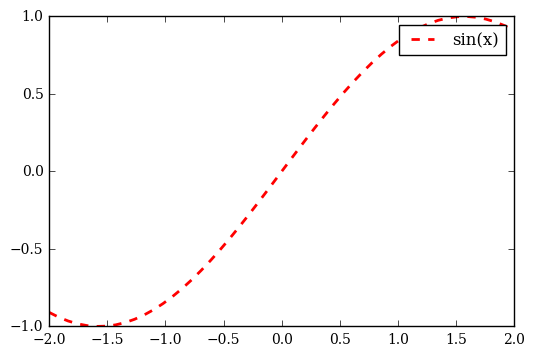

In [157]:
x = np.linspace(-2, 2, 50) #Radians
y = np.sin(x)
plotsin(x, y, 'ratata','ratat', 'ratatat', 5, 7, color='r', lw=2, ls='--', label='sin(x)')

In [6]:
import pymc

ImportError: No module named pymc